# Foundations of Data Analysis - Lab assignment - Supervised learning

## Part 1 - Dataset

In [67]:
# Import the dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Fix SSL exception
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#### Task 1a: Load data, investigate the sets

In [68]:
# Import data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [69]:
# Class names from https://www.cs.toronto.edu/~kriz/cifar.html 
labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

In [70]:
# Group all feature indexes by classes
y_train_by_class = np.array([np.where(y_train == i)[0] for i in range(10)])
y_test_by_class = np.array([np.where(y_test == i)[0] for i in range(10)])

In [71]:
# Calculate metrics
df = pd.DataFrame({
    "Metric": [
        "Number of training samples", 
        "Number of test samples", 
        "Size of the images", 
        "Number of color channels", 
        "Number of classes", 
        "Number of samples for each class", 
        "Class label corresponding to each class"
    ],
    "Value": [
        x_train.shape[0], 
        x_test.shape[0], 
        f"{x_train.shape[1]} x {x_train.shape[2]}", 
        x_train.shape[3], 
        len(labels),
        f"Training set - {y_train_by_class.shape[1]} samples by class, Test set - {y_test_by_class.shape[1]} samples by class", 
        ", ".join([f"{i} - {labels[i]}" for i in range(10)])]
})

# Set max column width so that all labels can fit
pd.options.display.max_colwidth = 200

# Display the results
display(df)

,Metric,Value
0,Number of training samples,50000
1,Number of test samples,10000
2,Size of the images,32 x 32
3,Number of color channels,3
4,Number of classes,10
5,Number of samples for each class,"Training set - 5000 samples by class, Test set - 1000 samples by class"
6,Class label corresponding to each class,"0 - Airplane, 1 - Automobile, 2 - Bird, 3 - Cat, 4 - Deer, 5 - Dog, 6 - Frog, 7 - Horse, 8 - Ship, 9 - Truck"


#### Task 1b: Rescale RGB values

In [72]:
# Rescale RGB values from 0-255 to 0-1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

# Flatten y values
y_train = y_train.reshape(-1);
y_test = y_test.reshape(-1);

#### Task 1c: Plot images and means

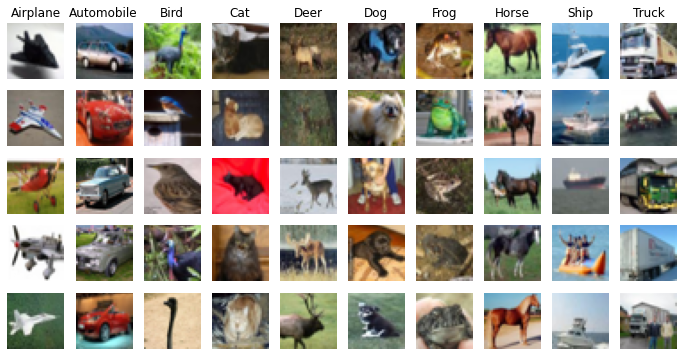

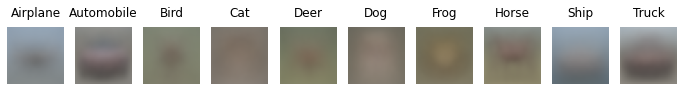

In [73]:
# Define subplots for figure 1
f1, axes1 = plt.subplots(figsize=(12, 6) , nrows=1, ncols=10) 
# Define labels plot
for label, ax in zip(labels, axes1):
    ax.set_title(label)
    ax.axis("off")
# Create plots with 5 images for each class
for i in range(5):
    for j in range(10):
        ax = f1.add_subplot(5, 10, i * 10 + j + 1)
        ax.axis("off")
        ax.imshow(x_train[y_train_by_class[j][i]])

# Define subplots for figure 2
f2, axes2 = plt.subplots(figsize=(12, 1.2) , nrows=1, ncols=10) 
# Define labels plot
for label, ax in zip(labels, axes2):
    ax.set_title(label)
    ax.axis("off")
# Create plots with means for each class
for i in range(10):
    ax = f2.add_subplot(1, 10, i + 1)
    ax.axis("off")
    ax.imshow(np.mean(np.array([x_train[i] for i in y_train_by_class[i]]), axis=0))

#### Task 1d: Chance level

Class probabilities are equal for this dataset, because each class have the same number of samples. 
For `CIFAR-10` dataset we have `10` classes and each class has `6000` samples.
Which means that the label is chosen randomly with equal probability for each class.
The chance level of this dataset is equal to `1 / n = 1 / 10`.

In [77]:
# Calculate chance level by randomly choosing class and comparing to the class from the source data
correct_predictions = 0;
for i in range(len(y_train)):
    # Choose random class
    prediction = random.randint(0, 9)
    # Compare the randomly predicted value with true value
    correct_predictions += 1 if prediction == y_train[i] else 0
# Calculate the chance level by dividing the number of correct predictions by the total number of tries
chance_level = (correct_predictions / len(y_train)) * 100
# Display the resulting chance level. Should be about 10%
print(f"Chance level: {round(chance_level, 2)} %")

Chance level: 10.01 %


## Part 2 - Random forest

#### Task 2a: Train Random Forest Classifier

In [78]:
# Reshape training and test datasets to 1 dimension
flat_x_train = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
flat_x_test = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

In [44]:
# Set the random seed
np.random.seed(1111)

# Define the random forest classifier with 1000 trees, use all available processors
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

# Train the model
rfc.fit(flat_x_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

#### Task 2b: Evaluate Random Forest Classifier

In [45]:
# Predict the classes for test set
rfc_predict = rfc.predict(flat_x_test)

#### Task 2c: Compute the accuracy

In [46]:
# Compute and print the accuracy of the classifier
print(f"Accuracy: {metrics.accuracy_score(y_test, rfc_predict)}")

Accuracy: 0.4956


#### Task 2d: Compute the confusion matrix

In [48]:
# Compute confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, rfc_predict)

# Put the computed confusion matrix into DataFrame with user-friendly labels for columns and rows
df = pd.DataFrame(
    confusion_matrix,
    index=[f"Actual: {label}" for label in labels],
    columns=[f"Predicted: {label}" for label in labels]
)

# Display confusion matrix
display(df)

,Predicted: Airplane,Predicted: Automobile,Predicted: Bird,Predicted: Cat,Predicted: Deer,Predicted: Dog,Predicted: Frog,Predicted: Horse,Predicted: Ship,Predicted: Truck
Actual: Airplane,570,29,54,13,28,17,26,27,168,68
Actual: Automobile,24,577,10,32,16,31,38,27,61,184
Actual: Bird,98,42,354,78,127,56,127,59,28,31
Actual: Cat,52,36,56,286,75,183,156,58,20,78
Actual: Deer,51,18,138,46,412,40,152,99,24,20
Actual: Dog,30,26,80,138,68,420,87,91,26,34
Actual: Frog,10,29,73,60,87,44,620,26,6,45
Actual: Horse,47,39,42,44,86,79,52,495,23,93
Actual: Ship,80,80,18,21,18,36,13,22,633,79
Actual: Truck,48,154,16,28,14,13,29,38,71,589


#### Task 2e

For some of the classes classifier often confuses which results in wrong predictions.
The best explanation is that the flat structure of the images given to the model doesn't work well for feature selection. Here we have more complex features than just flat pixels' RGB channels.
Maybe we could archive better scores with some data preprocessing. 

The classifier performs relatively better for `Airplane`, `Automobile`, `Frog`, `Ship`, `Truck` classes.

The classifier often confuses for the following classes (as we can see at the plot from task 1c, the means are also similar for those classes):
    
1. **Cat and Dog** 
    
    `Cat` and `Dog` images are misclassified the most frequently

    |             | Predicted: Cat | Predicted: Dog |
    | :---:       | :---:          | :---:          |
    | Actual: Cat | 286            | 183            |
    | Actual: Dog | 138            | 420            |

2. **Bird, Deer**
    
    |              | Predicted: Bird | Predicted: Deer |
    | :---:        | :---:           | :---:           |
    | Actual: Bird | 354             | 127             |
    | Actual: Deer | 138             | 412             |

### Part 3 -  Neural networks

#### Task 3: General Setup

##### Define one-hot-encoded output

In [79]:
cat_y_train = to_categorical(y_train)
cat_y_test = to_categorical(y_test)

##### Define necessary functions

In [80]:
# Plot learning curves
def plot_learning_curves(h):
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Learning curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

#### Task 3 a - d:  Fully connected neural network (20 nodes)

In [18]:
# Set random seed
np.random.seed(2222)
tf.random.set_seed(2222)

# Define the model
nn_20 = Sequential()
nn_20.add(Dense(20, activation="relu", input_shape=(32 * 32 * 3,)))
nn_20.add(Dense(10, activation="softmax"))

# Compile the model
nn_20.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])

# Print model summary. Model has 61 670 parameters in total
nn_20.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                61460     
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 61,670
Trainable params: 61,670
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the model
h_20 = nn_20.fit(flat_x_train, cat_y_train, validation_split=0.2, epochs=30, verbose=0)

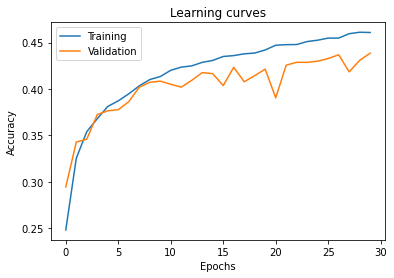

In [20]:
# Plot learning curves using history
plot_learning_curves(h_20)

Accuracy results:
- The model accuracy on train set: ~ 0.45
- The model accuracy on validation set: ~ 0.43

Model is overfitted when it performs well on training set, but performs bad for the test set (new data). So it has to have low training error and high validation error to be overfitted.

Here we have almost equal accuracies both on train and test sets, and these accuracies are relatively low, which means that both train and test errors are high enough. This means that the model is probably underfitted.

The classifier from the second part had a similar accuracy, so the problem may be also in the training set: too similar images between different classes - which confuses the model.

Also, this type of neural network may be not the best option for such type of images. It performs well on simple images.
CNN suits better for this dataset, because of its feature detection strategy (also, CNN can handle different feature locations on the image)

*What can we do?*
- Try to increase the number of neurons in the hidden layer
- Try to increase the duration of training (by increasing epochs)
- Try to add more hidden layers
- Try to add more traing data 

#### Task 3e: Fully connected neural network (100 nodes)

In [21]:
# Set random seed
np.random.seed(3333)
tf.random.set_seed(3333)

# Define the model
nn_100 = Sequential()
nn_100.add(Dense(100, activation="relu", input_shape=(32 * 32 * 3,)))
nn_100.add(Dense(10, activation="softmax"))

# Compile the model
nn_100.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])

# Print model summary. Model has 308 310 parameters in total
nn_100.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 308,310
Trainable params: 308,310
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Fit the model
h_100 = nn_100.fit(flat_x_train, cat_y_train, validation_split=0.2, epochs=30, verbose=0)

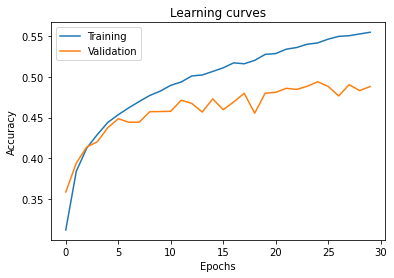

In [23]:
# Plot learning curves using history
plot_learning_curves(h_100)

#### Task 3f: Convolutional neural network

I used this [video](https://www.youtube.com/watch?v=zfiSAzpy9NM&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=23)  to better understand CNN models

In [24]:
# Set random seed
np.random.seed(4444)
tf.random.set_seed(4444)

# Define the model
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)))
cnn.add(MaxPooling2D((3, 3)))
cnn.add(Flatten())
cnn.add(Dense(10, activation="softmax"))

# Compile the model
cnn.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])

# Print model summary. Model has 65 802 parameters in total
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                64010     
                                                                 
Total params: 65,802
Trainable params: 65,802
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Fit the model
h_cnn = cnn.fit(x_train, cat_y_train, validation_split=0.2, epochs=30, verbose=0)

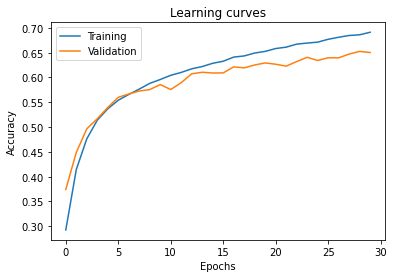

In [26]:
# Plot learning curves using history
plot_learning_curves(h_cnn)

**Convolutional layer** performs feature extraction using convolution operation. 

*Filter* - some pattern that we search for in the image - array of weights. 

We can configure the number of filters (`filters` arg) and their size (`kernel_size` arg) for the layer. 
The number of filters determines the number of features we want to search for. 
Filter size is less than the image size. 

We apply the filter to different parts of the image sequentially using the dot product to get a feature map.
After that we use `relu` activation to make the model non-linear. 

**Max Pooling layer** reduces the size of input. It sequentially takes the blocks of size n x n of the image (we can specify the size of this block during layer creation) and reduces each block to one value (in case of max pooling it chooses the max value from the block).

#### Task 3g: Creating custom model

I have read a lot of research papers on CNN optimization in order to make this exercise. These are papers that helped the most:
- [Stochastic Optimization of Plain Convolutional Neural Networks with Simple methods](https://arxiv.org/ftp/arxiv/papers/2001/2001.08856.pdf)
- [Optimizing of Convolutional Neural Network Accelerator](https://www.intechopen.com/chapters/60223)
- [Determining Ground Elevations Covered by Vegetation on Construction Sites Using Drone-Based Orthoimage and Convolutional Neural Network](https://www.researchgate.net/publication/344155641_Determining_Ground_Elevations_Covered_by_Vegetation_on_Construction_Sites_Using_Drone-Based_Orthoimage_and_Convolutional_Neural_Network#pfb)

I tried different variations of changing the following model characteristics:
- **Convolutional layers**
  + In general, increasing the number of convolutional layers helped to increase the accuracy of the model, but it really depends on the order of applying these layers and their characteristics. 
  + If there are a lot of layers, model training becomes a really long operation. The best option was to use three blocks containing two `Conv2D` layers, each followed by a max pooling layer. This approach increased a chance for the model to create more complex features. 
  + As suggested in a lot of research papers, it is helpful to increase the number of filters with each convolutional layer. It helps to extract useful features when the data is noisy (in the beginning), and then create more complex features from it.
  + Padding `same` is used to prevent reducing the dimensions too quickly
- **Pooling layers**
  + Many of the research papers suggest using Pooling layers after each convolutional layer or a block of them
  + The pooling layer worked well for this dataset when using after each convolutional layer. It reduces the computations and extracts the most important features. Also, it helps to increase the accuracy of detecting features in different locations on the image
  + I tested two types of pooling layers `MaxPooling2D` and `AveragePooling2D`. Usually max pooling helps to detect sharp features (like lines, numbers, points) and average pooling detects smooth features better. My assumption was that average pooling will work better for this dataset, but actually max pooling occured to be the best option
- **Dropout layers**
  + Dropout randomly removes the specified number of neurins from the networks. It helps to prevent overfitting.
  + As suggested in different research papers, the dropout layers rarely perform well inside the CNN network, but can really help for fully-connected part. So I used Dropout layers right after the CNN part and inside the fully-connected part of the network
  + I tried different number of neurons to drop. There are a lot of techniques (increasing this number with each layer, using fixed 0.2, using fixed 0.5, etc). In combination with other methods applied to the network the value of 0.5 worked the best.
- **Dense layers**
  + I tried using different variations of fully-connected network that follows the CNN part
  + The best option was to use stronger fully-connected classification part (than just 1 layer)
  + Also I tried using more and less neurons for this part. For this dataset and the specified CNN part, wide Dense layers work best
- **Optimizers**
  + I chose to use `Adam` optimizer because it uses adaptive learning rate, and according to many researches, outperforms SGD.

In [83]:
# Set random seed
np.random.seed(5555)
tf.random.set_seed(5555)

# Define the model
custom_cnn = Sequential()
custom_cnn.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)))
custom_cnn.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
custom_cnn.add(MaxPooling2D((2, 2)))
custom_cnn.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
custom_cnn.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
custom_cnn.add(MaxPooling2D((2, 2)))
custom_cnn.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
custom_cnn.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
custom_cnn.add(MaxPooling2D((2, 2)))
custom_cnn.add(Dropout(0.5))

custom_cnn.add(Flatten())
custom_cnn.add(Dense(2048, activation="relu"))
custom_cnn.add(Dropout(0.5))
custom_cnn.add(Dense(1024, activation="relu"))
custom_cnn.add(Dropout(0.5))
custom_cnn.add(Dense(10, activation="softmax"))

# Compile the model
custom_cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])


# Print model summary. Model has 6 591 786 parameters in total
custom_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

In [84]:
# Fit the model
h_custom_cnn = custom_cnn.fit(x_train, cat_y_train, validation_split=0.05, epochs=15, batch_size=256)

Epoch 1/15
186/186 [==============================] - 225s 1s/step - loss: 1.7637 - accuracy: 0.3374 - val_loss: 1.4175 - val_accuracy: 0.4896
Epoch 2/15
186/186 [==============================] - 220s 1s/step - loss: 1.3259 - accuracy: 0.5164 - val_loss: 1.1435 - val_accuracy: 0.6036
Epoch 3/15
186/186 [==============================] - 220s 1s/step - loss: 1.0943 - accuracy: 0.6070 - val_loss: 0.9610 - val_accuracy: 0.6748
Epoch 4/15
186/186 [==============================] - 222s 1s/step - loss: 0.9478 - accuracy: 0.6651 - val_loss: 0.8259 - val_accuracy: 0.7112
Epoch 5/15
186/186 [==============================] - 224s 1s/step - loss: 0.8369 - accuracy: 0.7038 - val_loss: 0.7455 - val_accuracy: 0.7524
Epoch 6/15
186/186 [==============================] - 213s 1s/step - loss: 0.7699 - accuracy: 0.7320 - val_loss: 0.6708 - val_accuracy: 0.7772
Epoch 7/15
186/186 [==============================] - 223s 1s/step - loss: 0.6948 - accuracy: 0.7588 - val_loss: 0.6788 - val_accuracy: 0.7672

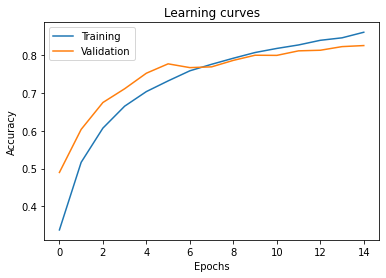

Accuracy: 0.8044999837875366


In [85]:
# Plot learning curves using history
plot_learning_curves(h_custom_cnn)

# Evaluate the model
_, accuracy_custom_cnn = custom_cnn.evaluate(x_test, cat_y_test, verbose=0)

print(f"Accuracy: {accuracy_custom_cnn}")

***Why is it important to compare the models with a validation set first, and only then evaluate the chosen model on the test set?***

First, we should define what these sets mean:
- *Training set* - is a set that is used to fit the model
- *Validation set* - is a set that is used to check the model performance (accuracy and other metrics) during the training, so that we can tune the parameters, determine the overfitting, define the rules for early stopping etc.
- *Test set* - is used to evaluate the final model

Validation set doesn't give us an objective metric on a final model, because it is used during the training. We aim to tune the model in the way, when it performs well on the validation set. The accuracy on this set becomes biased over time.

Test set is applied to a final model and gives as unbiased results from the model evaluation, because we didn't use this data while training. So it is compleately new to the model.

In [86]:
# Predict the classes for test set
custom_cnn_predict = custom_cnn.predict(x_test)

In [88]:
# Compute and print the accuracy of the classifier
print(f"Accuracy: {metrics.accuracy_score(np.argmax(cat_y_test, axis=1), np.argmax(custom_cnn_predict, axis=1))}")

# Compute confusion matrix
custom_cnn_confusion_matrix = metrics.confusion_matrix(np.argmax(cat_y_test, axis=1), np.argmax(custom_cnn_predict, axis=1))

# Put the computed confusion matrix into DataFrame with user-friendly labels for columns and rows
custom_cnn_df = pd.DataFrame(
    custom_cnn_confusion_matrix,
    index=[f"Actual: {label}" for label in labels],
    columns=[f"Predicted: {label}" for label in labels]
)

# Display confusion matrix
display(custom_cnn_df)

Accuracy: 0.8045


,Predicted: Airplane,Predicted: Automobile,Predicted: Bird,Predicted: Cat,Predicted: Deer,Predicted: Dog,Predicted: Frog,Predicted: Horse,Predicted: Ship,Predicted: Truck
Actual: Airplane,866,15,26,13,6,2,6,15,34,17
Actual: Automobile,9,916,1,4,2,0,9,5,18,36
Actual: Bird,62,1,689,38,63,38,69,28,8,4
Actual: Cat,19,3,58,622,46,106,82,44,12,8
Actual: Deer,20,2,46,39,751,15,62,59,6,0
Actual: Dog,8,5,37,148,38,695,22,44,3,0
Actual: Frog,5,2,27,31,14,6,908,3,3,1
Actual: Horse,8,0,25,29,35,24,5,870,2,2
Actual: Ship,65,17,5,13,3,0,5,3,877,12
Actual: Truck,32,76,5,7,1,3,4,11,10,851
